In [1]:
# AeroCNN-I
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import datetime
%matplotlib inline

In [2]:
n_kernel=25
n_units=512
l2Regularizer=1e-09
kernel_size1 = 2
kernel_size2 = 5
n_grid = 101
strides = 2
input_size = 49

In [3]:
alpha = np.linspace(-10,20,16).reshape((16,1))

In [4]:
aa = np.zeros((16*133,1))
for i in range(0, 133):
    aa[16*i:16*(i+1), :] = alpha[:,:]

In [5]:
aa = aa.reshape((133, 16, 1, 1))

In [6]:
os.chdir('D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out')

In [7]:
origin = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"
origin_data = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"
origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"

In [8]:
folders_orig = os.listdir(origin_data)
folders = [file for file in folders_orig if file.startswith('airfoil')]

In [9]:
coord_df = pd.DataFrame()
counter = 1
for i in range(1, 134):
    coord_file_name = origin_coord + "\\airfoil" + str(i) + "\\airfoilOut"+ str(i) + ".txt"
    data = pd.read_csv(coord_file_name, sep = ",", header=None)
    while counter < 17:
        coord_df = pd.concat([coord_df, data], axis=0)
        counter += 1
    counter=1

In [10]:
coord_np = coord_df.iloc[:, :].values

In [11]:
coord = coord_np.reshape((len(folders), 16, 2, 50))

In [12]:
cl_df = pd.DataFrame()
for i in range(1, 134):
    for alpha_ in alpha:
        cl_name = origin_coord + "\\airfoil" + str(i) + "\\"+ str(int(alpha_)) + "\\Cl_" + str(i) + "_"+ str(int(alpha_)) +".txt"
        data = pd.read_csv(cl_name, sep = ",", header=None)
        cl_df = pd.concat([cl_df, data], axis=0)

In [13]:
cd_df = pd.DataFrame()
for i in range(1, 134):
    for alpha_ in alpha:
        cd_name = origin_coord + "\\airfoil" + str(i) + "\\"+ str(int(alpha_)) + "\\Cd_" + str(i) + "_"+ str(int(alpha_)) +".txt"
        data = pd.read_csv(cd_name, sep = ",", header=None)
        cd_df = pd.concat([cd_df, data], axis=0)

In [14]:
cl = cl_df.iloc[:, :].values.reshape((-1,1))
cd = cd_df.iloc[:, :].values.reshape((-1,1))
y = np.hstack((cl, cd))

In [15]:
y = y.reshape((133, 16, 2, 1))

In [16]:
file_name = origin_data + "\\AirfoilIndexList.xlsx"
airfoilName_df = pd.read_excel(file_name)
geometry_orig = airfoilName_df.iloc[:, 1].values

In [17]:
geometry = np.zeros((133*16,1))
geometry = geometry.astype(np.string_)
for i in geometry_orig:
    index_ = np.where(geometry_orig==i)
    for j in range(0,16):
        geometry[16*index_[0]+j,:] = np.asarray(i)

In [18]:
geometry.shape

(2128, 1)

In [19]:
geometry = geometry.reshape((133, 16, 1))

In [20]:
x_train, x_test, aa_train, aa_test, geo_train, geo_test, y_train, y_test = train_test_split(coord, aa, geometry, y, test_size=0.3, random_state=1)

In [21]:
x_train = x_train.reshape((x_train.shape[0]*x_train.shape[1], x_train.shape[2], x_train.shape[3], 1))
x_test = x_test.reshape((x_test.shape[0]*x_test.shape[1], x_test.shape[2], x_test.shape[3], 1))
aa_train = aa_train.reshape((aa_train.shape[0]*aa_train.shape[1], aa_train.shape[2], aa_train.shape[3]))
aa_test = aa_test.reshape((aa_test.shape[0]*aa_test.shape[1], aa_test.shape[2], aa_test.shape[3]))
geo_train = geo_train.reshape((geo_train.shape[0]*geo_train.shape[1], geo_train.shape[2]))
geo_test = geo_test.reshape((geo_test.shape[0]*geo_test.shape[1], geo_test.shape[2]))
y_train = y_train.reshape((y_train.shape[0]*y_train.shape[1], y_train.shape[2], y_train.shape[3]))
y_test = y_test.reshape((y_test.shape[0]*y_test.shape[1], y_test.shape[2], y_test.shape[3]))

In [23]:
input_coord = tf.keras.Input(shape=(2, 50, 1))
input_alpha = tf.keras.Input(shape=(1,1))

x_conv = tf.keras.layers.Conv2D(n_kernel, (kernel_size1, kernel_size2), strides=(strides, strides),
                                activation='relu', padding='same',
                                kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer),
                                name='Conv2DLayer')(input_coord)
x_ = tf.keras.layers.MaxPooling2D((1,2))(x_conv)
reshape1 = tf.keras.layers.Flatten()(x_)
reshape2 = tf.keras.layers.Reshape((1,))(input_alpha)
x_concat = tf.keras.layers.Concatenate(axis=1)([reshape1, reshape2])

x_ = tf.keras.layers.Dense(units=200, activation='relu', name='firstHiddenLayerSensor',
                           kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer))(x_concat)
x_ = tf.keras.layers.Dense(units=100, activation='relu', name='secondHiddenLayerSensor',
                           kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer))(x_)

output_data = tf.keras.layers.Dense(units=2, activation=None, name='outputLayerSensor')(x_)
output_image = tf.keras.layers.Reshape((2, 1))(output_data)
# AeroCNN-I
model = tf.keras.Model([input_coord, input_alpha], output_image)

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 2, 50, 1)]   0           []                               
                                                                                                  
 Conv2DLayer (Conv2D)           (None, 1, 25, 25)    275         ['input_3[0][0]']                
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 1, 12, 25)   0           ['Conv2DLayer[0][0]']            
                                                                                                  
 input_4 (InputLayer)           [(None, 1, 1)]       0           []                               
                                                                                              

In [25]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [26]:
start = datetime.datetime.now()
history = model.fit([x_train,aa_train], y_train, epochs=5000, shuffle=True)
end = datetime.datetime.now()

Epoch 1/5000
47/47 [==============================] - 5s 7ms/step - loss: 0.0557 - rmse: 0.2361
Epoch 2/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0150 - rmse: 0.1223
Epoch 3/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0124 - rmse: 0.1112
Epoch 4/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0107 - rmse: 0.1034
Epoch 5/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0113 - rmse: 0.1063
Epoch 6/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0099 - rmse: 0.0992
Epoch 7/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0101 - rmse: 0.1006
Epoch 8/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0100 - rmse: 0.1001
Epoch 9/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0127 - rmse: 0.1125
Epoch 10/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0095 - rmse: 0.0975
Epoch 11/5000
47/47 [==================

47/47 [==============================] - 0s 6ms/step - loss: 0.0047 - rmse: 0.0686
Epoch 169/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0044 - rmse: 0.0664
Epoch 170/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0044 - rmse: 0.0661
Epoch 171/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0047 - rmse: 0.0686
Epoch 172/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0045 - rmse: 0.0670
Epoch 173/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0050 - rmse: 0.0710
Epoch 174/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0048 - rmse: 0.0696
Epoch 175/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0050 - rmse: 0.0704
Epoch 176/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0044 - rmse: 0.0663
Epoch 177/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0044 - rmse: 0.0661
Epoch 178/5000
47/47 [=============

47/47 [==============================] - 0s 6ms/step - loss: 0.0031 - rmse: 0.0559
Epoch 335/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0033 - rmse: 0.0570
Epoch 336/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0033 - rmse: 0.0572
Epoch 337/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0032 - rmse: 0.0567
Epoch 338/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0030 - rmse: 0.0552
Epoch 339/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0031 - rmse: 0.0559
Epoch 340/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0034 - rmse: 0.0580
Epoch 341/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0029 - rmse: 0.0539
Epoch 342/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0029 - rmse: 0.0540
Epoch 343/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0030 - rmse: 0.0544
Epoch 344/5000
47/47 [=============

47/47 [==============================] - 0s 6ms/step - loss: 0.0026 - rmse: 0.0507
Epoch 501/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0022 - rmse: 0.0465
Epoch 502/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0021 - rmse: 0.0458
Epoch 503/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0023 - rmse: 0.0480
Epoch 504/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0021 - rmse: 0.0459
Epoch 505/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0021 - rmse: 0.0459
Epoch 506/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0022 - rmse: 0.0464
Epoch 507/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0022 - rmse: 0.0467
Epoch 508/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0020 - rmse: 0.0451
Epoch 509/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0021 - rmse: 0.0455
Epoch 510/5000
47/47 [=============

47/47 [==============================] - 0s 5ms/step - loss: 0.0017 - rmse: 0.0406
Epoch 667/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0015 - rmse: 0.0393
Epoch 668/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0016 - rmse: 0.0397
Epoch 669/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0017 - rmse: 0.0416
Epoch 670/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0014 - rmse: 0.0380
Epoch 671/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0015 - rmse: 0.0387
Epoch 672/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0016 - rmse: 0.0402
Epoch 673/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0016 - rmse: 0.0400
Epoch 674/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0019 - rmse: 0.0430
Epoch 675/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0016 - rmse: 0.0406
Epoch 676/5000
47/47 [=============

47/47 [==============================] - 0s 5ms/step - loss: 0.0011 - rmse: 0.0334
Epoch 833/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0014 - rmse: 0.0372
Epoch 834/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0015 - rmse: 0.0383
Epoch 835/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0012 - rmse: 0.0345
Epoch 836/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0017 - rmse: 0.0418
Epoch 837/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0015 - rmse: 0.0388
Epoch 838/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0013 - rmse: 0.0358
Epoch 839/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0013 - rmse: 0.0356
Epoch 840/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0017 - rmse: 0.0417
Epoch 841/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0014 - rmse: 0.0376
Epoch 842/5000
47/47 [=============

47/47 [==============================] - 0s 6ms/step - loss: 0.0022 - rmse: 0.0471
Epoch 998/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0023 - rmse: 0.0480
Epoch 999/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0018 - rmse: 0.0421
Epoch 1000/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0011 - rmse: 0.0335
Epoch 1001/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0011 - rmse: 0.0334
Epoch 1002/5000
47/47 [==============================] - 0s 5ms/step - loss: 9.1748e-04 - rmse: 0.0302
Epoch 1003/5000
47/47 [==============================] - 0s 5ms/step - loss: 7.8883e-04 - rmse: 0.0280
Epoch 1004/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.4346e-04 - rmse: 0.0290
Epoch 1005/5000
47/47 [==============================] - 0s 5ms/step - loss: 9.7493e-04 - rmse: 0.0312
Epoch 1006/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0012 - rmse: 0.0350
Epoch 1007/5

Epoch 1078/5000
47/47 [==============================] - 0s 5ms/step - loss: 7.0843e-04 - rmse: 0.0266
Epoch 1079/5000
47/47 [==============================] - 0s 5ms/step - loss: 7.2441e-04 - rmse: 0.0269
Epoch 1080/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.2965e-04 - rmse: 0.0287
Epoch 1081/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.7140e-04 - rmse: 0.0295
Epoch 1082/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.0848e-04 - rmse: 0.0284
Epoch 1083/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0020 - rmse: 0.0445
Epoch 1084/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0015 - rmse: 0.0391
Epoch 1085/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0011 - rmse: 0.0337
Epoch 1086/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0014 - rmse: 0.0377
Epoch 1087/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0016 - rms

47/47 [==============================] - 0s 5ms/step - loss: 8.5044e-04 - rmse: 0.0291
Epoch 1159/5000
47/47 [==============================] - 0s 5ms/step - loss: 6.8733e-04 - rmse: 0.0262
Epoch 1160/5000
47/47 [==============================] - 0s 5ms/step - loss: 6.6881e-04 - rmse: 0.0258
Epoch 1161/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0013 - rmse: 0.0356
Epoch 1162/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0013 - rmse: 0.0359
Epoch 1163/5000
47/47 [==============================] - 0s 5ms/step - loss: 7.1882e-04 - rmse: 0.0267
Epoch 1164/5000
47/47 [==============================] - 0s 5ms/step - loss: 7.0554e-04 - rmse: 0.0265
Epoch 1165/5000
47/47 [==============================] - 0s 5ms/step - loss: 7.4606e-04 - rmse: 0.0273
Epoch 1166/5000
47/47 [==============================] - 0s 5ms/step - loss: 6.4606e-04 - rmse: 0.0254
Epoch 1167/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0015 - rmse: 0.038

47/47 [==============================] - 0s 6ms/step - loss: 0.0011 - rmse: 0.0330
Epoch 1320/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.7172e-04 - rmse: 0.0295
Epoch 1321/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0010 - rmse: 0.0318
Epoch 1322/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0010 - rmse: 0.0319
Epoch 1323/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.9964e-04 - rmse: 0.0299
Epoch 1324/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0015 - rmse: 0.0391
Epoch 1325/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0012 - rmse: 0.0351
Epoch 1326/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0010 - rmse: 0.0322
Epoch 1327/5000
47/47 [==============================] - 0s 6ms/step - loss: 9.6972e-04 - rmse: 0.0311
Epoch 1328/5000
47/47 [==============================] - 0s 5ms/step - loss: 9.9010e-04 - rmse: 0.0314
Epoch 1329

47/47 [==============================] - 0s 5ms/step - loss: 7.0419e-04 - rmse: 0.0265
Epoch 1480/5000
47/47 [==============================] - 0s 5ms/step - loss: 9.7512e-04 - rmse: 0.0312
Epoch 1481/5000
47/47 [==============================] - 0s 6ms/step - loss: 9.6583e-04 - rmse: 0.0310
Epoch 1482/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0013 - rmse: 0.0354
Epoch 1483/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0028 - rmse: 0.0532
Epoch 1484/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0016 - rmse: 0.0399
Epoch 1485/5000
47/47 [==============================] - 0s 5ms/step - loss: 9.2880e-04 - rmse: 0.0304
Epoch 1486/5000
47/47 [==============================] - 0s 5ms/step - loss: 7.7150e-04 - rmse: 0.0277
Epoch 1487/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.3793e-04 - rmse: 0.0252
Epoch 1488/5000
47/47 [==============================] - 0s 5ms/step - loss: 5.9915e-04 - rmse: 0.024

47/47 [==============================] - 0s 5ms/step - loss: 0.0011 - rmse: 0.0327
Epoch 1639/5000
47/47 [==============================] - 0s 6ms/step - loss: 5.8913e-04 - rmse: 0.0242
Epoch 1640/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.0414e-04 - rmse: 0.0245
Epoch 1641/5000
47/47 [==============================] - 0s 6ms/step - loss: 4.7254e-04 - rmse: 0.0216
Epoch 1642/5000
47/47 [==============================] - 0s 6ms/step - loss: 4.5221e-04 - rmse: 0.0212
Epoch 1643/5000
47/47 [==============================] - 0s 5ms/step - loss: 4.3932e-04 - rmse: 0.0209
Epoch 1644/5000
47/47 [==============================] - 0s 5ms/step - loss: 4.5979e-04 - rmse: 0.0213
Epoch 1645/5000
47/47 [==============================] - 0s 5ms/step - loss: 3.7176e-04 - rmse: 0.0192
Epoch 1646/5000
47/47 [==============================] - 0s 6ms/step - loss: 4.7110e-04 - rmse: 0.0216
Epoch 1647/5000
47/47 [==============================] - 0s 6ms/step - loss: 3.6960e-04 - rms

47/47 [==============================] - 0s 5ms/step - loss: 4.5416e-04 - rmse: 0.0212
Epoch 1798/5000
47/47 [==============================] - 0s 6ms/step - loss: 5.0503e-04 - rmse: 0.0224
Epoch 1799/5000
47/47 [==============================] - 0s 5ms/step - loss: 5.3471e-04 - rmse: 0.0230
Epoch 1800/5000
47/47 [==============================] - 0s 5ms/step - loss: 3.5076e-04 - rmse: 0.0186
Epoch 1801/5000
47/47 [==============================] - 0s 6ms/step - loss: 3.5686e-04 - rmse: 0.0188
Epoch 1802/5000
47/47 [==============================] - 0s 5ms/step - loss: 3.5751e-04 - rmse: 0.0188
Epoch 1803/5000
47/47 [==============================] - 0s 5ms/step - loss: 4.0455e-04 - rmse: 0.0200
Epoch 1804/5000
47/47 [==============================] - 0s 6ms/step - loss: 4.6157e-04 - rmse: 0.0214
Epoch 1805/5000
47/47 [==============================] - 0s 6ms/step - loss: 5.3737e-04 - rmse: 0.0231
Epoch 1806/5000
47/47 [==============================] - 0s 5ms/step - loss: 4.3415e-04 -

47/47 [==============================] - 0s 5ms/step - loss: 3.4389e-04 - rmse: 0.0184
Epoch 1878/5000
47/47 [==============================] - 0s 5ms/step - loss: 3.0024e-04 - rmse: 0.0172
Epoch 1879/5000
47/47 [==============================] - 0s 5ms/step - loss: 4.5197e-04 - rmse: 0.0212
Epoch 1880/5000
47/47 [==============================] - 0s 5ms/step - loss: 5.0694e-04 - rmse: 0.0224
Epoch 1881/5000
47/47 [==============================] - 0s 5ms/step - loss: 5.5647e-04 - rmse: 0.0235
Epoch 1882/5000
47/47 [==============================] - 0s 5ms/step - loss: 4.5561e-04 - rmse: 0.0212
Epoch 1883/5000
47/47 [==============================] - 0s 5ms/step - loss: 4.6537e-04 - rmse: 0.0215
Epoch 1884/5000
47/47 [==============================] - 0s 5ms/step - loss: 4.1036e-04 - rmse: 0.0201
Epoch 1885/5000
47/47 [==============================] - 0s 5ms/step - loss: 3.9763e-04 - rmse: 0.0198
Epoch 1886/5000
47/47 [==============================] - 0s 5ms/step - loss: 4.2797e-04 -

47/47 [==============================] - 0s 6ms/step - loss: 8.7665e-04 - rmse: 0.0295
Epoch 2036/5000
47/47 [==============================] - 0s 5ms/step - loss: 7.4725e-04 - rmse: 0.0272
Epoch 2037/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.6603e-04 - rmse: 0.0257
Epoch 2038/5000
47/47 [==============================] - 0s 5ms/step - loss: 6.5886e-04 - rmse: 0.0256
Epoch 2039/5000
47/47 [==============================] - 0s 5ms/step - loss: 4.4824e-04 - rmse: 0.0211
Epoch 2040/5000
47/47 [==============================] - 0s 5ms/step - loss: 4.6769e-04 - rmse: 0.0215
Epoch 2041/5000
47/47 [==============================] - 0s 5ms/step - loss: 4.1757e-04 - rmse: 0.0203
Epoch 2042/5000
47/47 [==============================] - 0s 6ms/step - loss: 3.4859e-04 - rmse: 0.0185
Epoch 2043/5000
47/47 [==============================] - 0s 5ms/step - loss: 3.1311e-04 - rmse: 0.0176
Epoch 2044/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.8955e-04 -

47/47 [==============================] - 0s 6ms/step - loss: 4.4789e-04 - rmse: 0.0210
Epoch 2194/5000
47/47 [==============================] - 0s 6ms/step - loss: 3.4536e-04 - rmse: 0.0184
Epoch 2195/5000
47/47 [==============================] - 0s 5ms/step - loss: 3.5142e-04 - rmse: 0.0186
Epoch 2196/5000
47/47 [==============================] - 0s 5ms/step - loss: 3.5683e-04 - rmse: 0.0188
Epoch 2197/5000
47/47 [==============================] - 0s 6ms/step - loss: 3.3974e-04 - rmse: 0.0183
Epoch 2198/5000
47/47 [==============================] - 0s 5ms/step - loss: 4.2728e-04 - rmse: 0.0205
Epoch 2199/5000
47/47 [==============================] - 0s 5ms/step - loss: 3.4358e-04 - rmse: 0.0184
Epoch 2200/5000
47/47 [==============================] - 0s 6ms/step - loss: 4.3922e-04 - rmse: 0.0208
Epoch 2201/5000
47/47 [==============================] - 0s 5ms/step - loss: 4.4628e-04 - rmse: 0.0210
Epoch 2202/5000
47/47 [==============================] - 0s 5ms/step - loss: 3.4541e-04 -

47/47 [==============================] - 0s 5ms/step - loss: 3.7584e-04 - rmse: 0.0193
Epoch 2352/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.8928e-04 - rmse: 0.0169
Epoch 2353/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.8363e-04 - rmse: 0.0167
Epoch 2354/5000
47/47 [==============================] - 0s 5ms/step - loss: 3.2562e-04 - rmse: 0.0179
Epoch 2355/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.9613e-04 - rmse: 0.0171
Epoch 2356/5000
47/47 [==============================] - 0s 5ms/step - loss: 3.1408e-04 - rmse: 0.0176
Epoch 2357/5000
47/47 [==============================] - 0s 5ms/step - loss: 4.6050e-04 - rmse: 0.0213
Epoch 2358/5000
47/47 [==============================] - 0s 6ms/step - loss: 4.6058e-04 - rmse: 0.0213
Epoch 2359/5000
47/47 [==============================] - 0s 5ms/step - loss: 3.5096e-04 - rmse: 0.0186
Epoch 2360/5000
47/47 [==============================] - 0s 5ms/step - loss: 3.2122e-04 -

47/47 [==============================] - 0s 6ms/step - loss: 4.4367e-04 - rmse: 0.0209
Epoch 2510/5000
47/47 [==============================] - 0s 6ms/step - loss: 3.0669e-04 - rmse: 0.0174
Epoch 2511/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.5577e-04 - rmse: 0.0158
Epoch 2512/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.7341e-04 - rmse: 0.0164
Epoch 2513/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.1392e-04 - rmse: 0.0144
Epoch 2514/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.3217e-04 - rmse: 0.0151
Epoch 2515/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.5351e-04 - rmse: 0.0158
Epoch 2516/5000
47/47 [==============================] - 0s 6ms/step - loss: 3.9029e-04 - rmse: 0.0196
Epoch 2517/5000
47/47 [==============================] - 0s 6ms/step - loss: 3.3521e-04 - rmse: 0.0182
Epoch 2518/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.9316e-04 -

47/47 [==============================] - 0s 6ms/step - loss: 4.2871e-04 - rmse: 0.0206
Epoch 2590/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.9733e-04 - rmse: 0.0171
Epoch 2591/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.8361e-04 - rmse: 0.0167
Epoch 2592/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.3496e-04 - rmse: 0.0151
Epoch 2593/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.2068e-04 - rmse: 0.0147
Epoch 2594/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.6015e-04 - rmse: 0.0160
Epoch 2595/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.5434e-04 - rmse: 0.0158
Epoch 2596/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.0480e-04 - rmse: 0.0141
Epoch 2597/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.4253e-04 - rmse: 0.0154
Epoch 2598/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.3769e-04 -

47/47 [==============================] - 0s 6ms/step - loss: 2.9403e-04 - rmse: 0.0170
Epoch 2748/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.8085e-04 - rmse: 0.0166
Epoch 2749/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.6482e-04 - rmse: 0.0161
Epoch 2750/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.1535e-04 - rmse: 0.0145
Epoch 2751/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.3508e-04 - rmse: 0.0151
Epoch 2752/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.0998e-04 - rmse: 0.0143
Epoch 2753/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.0726e-04 - rmse: 0.0142
Epoch 2754/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.1503e-04 - rmse: 0.0145
Epoch 2755/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.1725e-04 - rmse: 0.0145
Epoch 2756/5000
47/47 [==============================] - 0s 6ms/step - loss: 4.0294e-04 -

47/47 [==============================] - 0s 6ms/step - loss: 2.2854e-04 - rmse: 0.0149
Epoch 2906/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.8906e-04 - rmse: 0.0168
Epoch 2907/5000
47/47 [==============================] - 0s 6ms/step - loss: 3.1015e-04 - rmse: 0.0174
Epoch 2908/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.8110e-04 - rmse: 0.0166
Epoch 2909/5000
47/47 [==============================] - 0s 6ms/step - loss: 3.5693e-04 - rmse: 0.0187
Epoch 2910/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.8017e-04 - rmse: 0.0166
Epoch 2911/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.5135e-04 - rmse: 0.0157
Epoch 2912/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.8290e-04 - rmse: 0.0166
Epoch 2913/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.8049e-04 - rmse: 0.0166
Epoch 2914/5000
47/47 [==============================] - 0s 6ms/step - loss: 3.3502e-04 -

47/47 [==============================] - 0s 6ms/step - loss: 3.1769e-04 - rmse: 0.0177
Epoch 3064/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.9866e-04 - rmse: 0.0171
Epoch 3065/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.9212e-04 - rmse: 0.0169
Epoch 3066/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.6427e-04 - rmse: 0.0161
Epoch 3067/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.2348e-04 - rmse: 0.0147
Epoch 3068/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.3327e-04 - rmse: 0.0151
Epoch 3069/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.1236e-04 - rmse: 0.0144
Epoch 3070/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.0941e-04 - rmse: 0.0143
Epoch 3071/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.2335e-04 - rmse: 0.0147
Epoch 3072/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.2118e-04 -

47/47 [==============================] - 0s 6ms/step - loss: 2.5135e-04 - rmse: 0.0157
Epoch 3222/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.9803e-04 - rmse: 0.0171
Epoch 3223/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.3458e-04 - rmse: 0.0151
Epoch 3224/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.9421e-04 - rmse: 0.0137
Epoch 3225/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.8795e-04 - rmse: 0.0135
Epoch 3226/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.0339e-04 - rmse: 0.0140
Epoch 3227/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.4745e-04 - rmse: 0.0155
Epoch 3228/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.6578e-04 - rmse: 0.0161
Epoch 3229/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.5471e-04 - rmse: 0.0158
Epoch 3230/5000
47/47 [==============================] - 0s 6ms/step - loss: 4.2692e-04 -

47/47 [==============================] - 0s 5ms/step - loss: 4.9051e-04 - rmse: 0.0220
Epoch 3302/5000
47/47 [==============================] - 0s 5ms/step - loss: 3.9227e-04 - rmse: 0.0196
Epoch 3303/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.9000e-04 - rmse: 0.0168
Epoch 3304/5000
47/47 [==============================] - 0s 5ms/step - loss: 3.4974e-04 - rmse: 0.0185
Epoch 3305/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.2435e-04 - rmse: 0.0148
Epoch 3306/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.0147e-04 - rmse: 0.0140
Epoch 3307/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.8543e-04 - rmse: 0.0134
Epoch 3308/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.7224e-04 - rmse: 0.0129
Epoch 3309/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.6126e-04 - rmse: 0.0124
Epoch 3310/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.3861e-04 -

47/47 [==============================] - 0s 6ms/step - loss: 2.2965e-04 - rmse: 0.0149
Epoch 3460/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.2370e-04 - rmse: 0.0147
Epoch 3461/5000
47/47 [==============================] - 0s 6ms/step - loss: 3.2671e-04 - rmse: 0.0179
Epoch 3462/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.6377e-04 - rmse: 0.0160
Epoch 3463/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.8788e-04 - rmse: 0.0168
Epoch 3464/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.8788e-04 - rmse: 0.0168
Epoch 3465/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.0860e-04 - rmse: 0.0142
Epoch 3466/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.7956e-04 - rmse: 0.0132
Epoch 3467/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.0040e-04 - rmse: 0.0139
Epoch 3468/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.2677e-04 -

47/47 [==============================] - 0s 6ms/step - loss: 2.4105e-04 - rmse: 0.0153
Epoch 3618/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.6079e-04 - rmse: 0.0124
Epoch 3619/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.7929e-04 - rmse: 0.0131
Epoch 3620/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.2034e-04 - rmse: 0.0146
Epoch 3621/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.6819e-04 - rmse: 0.0162
Epoch 3622/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.5340e-04 - rmse: 0.0121
Epoch 3623/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.6688e-04 - rmse: 0.0127
Epoch 3624/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.5929e-04 - rmse: 0.0124
Epoch 3625/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.6031e-04 - rmse: 0.0124
Epoch 3626/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.7963e-04 -

47/47 [==============================] - 0s 6ms/step - loss: 3.0652e-04 - rmse: 0.0173
Epoch 3776/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.7459e-04 - rmse: 0.0164
Epoch 3777/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.1959e-04 - rmse: 0.0146
Epoch 3778/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.9231e-04 - rmse: 0.0169
Epoch 3779/5000
47/47 [==============================] - 0s 6ms/step - loss: 3.6762e-04 - rmse: 0.0190
Epoch 3780/5000
47/47 [==============================] - 0s 6ms/step - loss: 5.1379e-04 - rmse: 0.0225
Epoch 3781/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.5253e-04 - rmse: 0.0254
Epoch 3782/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.9830e-04 - rmse: 0.0263
Epoch 3783/5000
47/47 [==============================] - 0s 6ms/step - loss: 3.7455e-04 - rmse: 0.0192
Epoch 3784/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.9304e-04 -

47/47 [==============================] - 0s 6ms/step - loss: 6.8229e-04 - rmse: 0.0260
Epoch 3934/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.2164e-04 - rmse: 0.0248
Epoch 3935/5000
47/47 [==============================] - 0s 6ms/step - loss: 3.5293e-04 - rmse: 0.0186
Epoch 3936/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.2732e-04 - rmse: 0.0148
Epoch 3937/5000
47/47 [==============================] - 0s 6ms/step - loss: 3.3087e-04 - rmse: 0.0180
Epoch 3938/5000
47/47 [==============================] - 0s 6ms/step - loss: 3.7379e-04 - rmse: 0.0192
Epoch 3939/5000
47/47 [==============================] - 0s 5ms/step - loss: 2.7377e-04 - rmse: 0.0163
Epoch 3940/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.6580e-04 - rmse: 0.0126
Epoch 3941/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.5239e-04 - rmse: 0.0121
Epoch 3942/5000
47/47 [==============================] - 0s 5ms/step - loss: 1.5801e-04 -

47/47 [==============================] - 0s 6ms/step - loss: 1.5898e-04 - rmse: 0.0123
Epoch 4092/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.7795e-04 - rmse: 0.0131
Epoch 4093/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.3280e-04 - rmse: 0.0150
Epoch 4094/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.5947e-04 - rmse: 0.0159
Epoch 4095/5000
47/47 [==============================] - 0s 6ms/step - loss: 3.5658e-04 - rmse: 0.0187
Epoch 4096/5000
47/47 [==============================] - 0s 6ms/step - loss: 3.5746e-04 - rmse: 0.0187
Epoch 4097/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.2246e-04 - rmse: 0.0147
Epoch 4098/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.9329e-04 - rmse: 0.0136
Epoch 4099/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.4655e-04 - rmse: 0.0155
Epoch 4100/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.7165e-04 -

47/47 [==============================] - 0s 6ms/step - loss: 1.8314e-04 - rmse: 0.0133
Epoch 4250/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.4575e-04 - rmse: 0.0154
Epoch 4251/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.8887e-04 - rmse: 0.0135
Epoch 4252/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.3402e-04 - rmse: 0.0113
Epoch 4253/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.5584e-04 - rmse: 0.0122
Epoch 4254/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.8470e-04 - rmse: 0.0133
Epoch 4255/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.7325e-04 - rmse: 0.0129
Epoch 4256/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.5505e-04 - rmse: 0.0157
Epoch 4257/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.8291e-04 - rmse: 0.0166
Epoch 4258/5000
47/47 [==============================] - 0s 6ms/step - loss: 3.2787e-04 -

47/47 [==============================] - 0s 6ms/step - loss: 2.1641e-04 - rmse: 0.0145
Epoch 4408/5000
47/47 [==============================] - 0s 6ms/step - loss: 3.8631e-04 - rmse: 0.0195
Epoch 4409/5000
47/47 [==============================] - 0s 6ms/step - loss: 4.7000e-04 - rmse: 0.0215
Epoch 4410/5000
47/47 [==============================] - 0s 6ms/step - loss: 3.2882e-04 - rmse: 0.0179
Epoch 4411/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.7615e-04 - rmse: 0.0164
Epoch 4412/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.4534e-04 - rmse: 0.0117
Epoch 4413/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.2380e-04 - rmse: 0.0108
Epoch 4414/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.7097e-04 - rmse: 0.0128
Epoch 4415/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.4145e-04 - rmse: 0.0153
Epoch 4416/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.6818e-04 -

47/47 [==============================] - 0s 6ms/step - loss: 2.2573e-04 - rmse: 0.0148
Epoch 4566/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.2886e-04 - rmse: 0.0149
Epoch 4567/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.7493e-04 - rmse: 0.0129
Epoch 4568/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.5154e-04 - rmse: 0.0120
Epoch 4569/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.3679e-04 - rmse: 0.0114
Epoch 4570/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.2759e-04 - rmse: 0.0110
Epoch 4571/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.4184e-04 - rmse: 0.0116
Epoch 4572/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.4540e-04 - rmse: 0.0117
Epoch 4573/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.4240e-04 - rmse: 0.0116
Epoch 4574/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.7804e-04 -

Epoch 4645/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.2978e-04 - rmse: 0.0111
Epoch 4646/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.1697e-04 - rmse: 0.0105
Epoch 4647/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.7182e-04 - rmse: 0.0128
Epoch 4648/5000
47/47 [==============================] - 0s 6ms/step - loss: 3.1270e-04 - rmse: 0.0175
Epoch 4649/5000
47/47 [==============================] - 0s 6ms/step - loss: 3.7423e-04 - rmse: 0.0191
Epoch 4650/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.0689e-04 - rmse: 0.0141
Epoch 4651/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.5669e-04 - rmse: 0.0122
Epoch 4652/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.5527e-04 - rmse: 0.0122
Epoch 4653/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.9857e-04 - rmse: 0.0138
Epoch 4654/5000
47/47 [==============================] - 0s 6ms/step - lo

47/47 [==============================] - 0s 6ms/step - loss: 2.2326e-04 - rmse: 0.0147
Epoch 4804/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.0921e-04 - rmse: 0.0142
Epoch 4805/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.5753e-04 - rmse: 0.0158
Epoch 4806/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.9665e-04 - rmse: 0.0170
Epoch 4807/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.9156e-04 - rmse: 0.0168
Epoch 4808/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.7766e-04 - rmse: 0.0164
Epoch 4809/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.3474e-04 - rmse: 0.0151
Epoch 4810/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.6228e-04 - rmse: 0.0160
Epoch 4811/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.6651e-04 - rmse: 0.0161
Epoch 4812/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.1683e-04 -

47/47 [==============================] - 0s 6ms/step - loss: 1.5065e-04 - rmse: 0.0119
Epoch 4962/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.2697e-04 - rmse: 0.0109
Epoch 4963/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.2426e-04 - rmse: 0.0108
Epoch 4964/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.5489e-04 - rmse: 0.0121
Epoch 4965/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.3224e-04 - rmse: 0.0112
Epoch 4966/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.4882e-04 - rmse: 0.0119
Epoch 4967/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.5262e-04 - rmse: 0.0120
Epoch 4968/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.8189e-04 - rmse: 0.0132
Epoch 4969/5000
47/47 [==============================] - 0s 6ms/step - loss: 3.6244e-04 - rmse: 0.0188
Epoch 4970/5000
47/47 [==============================] - 0s 6ms/step - loss: 4.0566e-04 -

In [27]:
time = end - start
print("Training time:", time)

Training time: 0:22:15.562742


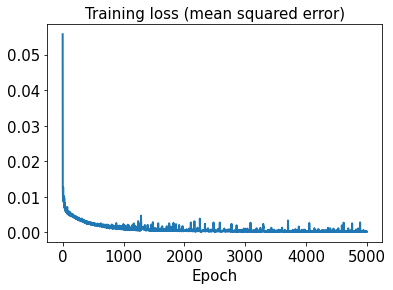

In [73]:
hist = history.history
plt.plot(hist['loss'], lw=2)
plt.title('Training loss (mean squared error)', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

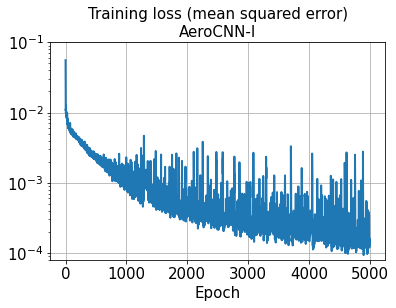

In [78]:
plt.plot(hist['loss'], lw=2)
plt.title('Training loss (mean squared error)\nAeroCNN-I', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.ylim([8e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.show()

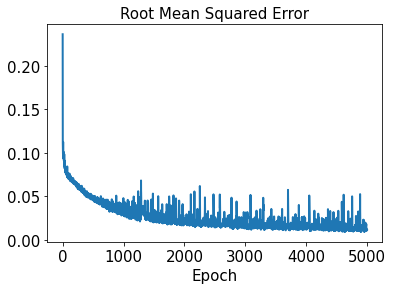

In [29]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

In [30]:
test_results = model.evaluate([x_train,aa_train])

47/47 [==============================] - 0s 2ms/step - loss: 7.9007e-06 - rmse: 0.0000e+00


In [31]:
decoded_train = model.predict([x_train,aa_train])

47/47 [==============================] - 0s 2ms/step


In [34]:
x_train.shape

(640, 2, 50)

In [32]:
decoded_test = model.predict([x_test, aa_test])

20/20 [==============================] - 0s 2ms/step


In [33]:
error_train_abs = np.abs(decoded_train - y_train)

In [34]:
error_test_abs = np.abs(decoded_test - y_test)

In [35]:
error_train_Cl_abs = np.abs(decoded_train[:,0,:] - y_train[:,0,:])

In [36]:
error_train_Cd_abs = np.abs(decoded_train[:,1,:] - y_train[:,1,:])

In [37]:
error_test_Cl_abs = np.abs(decoded_test[:,0,:] - y_test[:,0,:])

In [38]:
error_test_Cd_abs = np.abs(decoded_test[:,1,:] - y_test[:,1,:])

In [39]:
decoded_train.shape

(1488, 2, 1)

In [40]:
os.chdir("D:\\TrainedModels\\20220929")
model.save('AeroCNN-I_2FClayer.h5', overwrite=True, include_optimizer=True, save_format='h5')

In [41]:
l2_error_train = np.sqrt(np.sum((decoded_train - y_train)**2) / np.sum(y_train**2))
print(l2_error_train)

0.023110995005398892


In [42]:
l2_error_test = np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))
print(l2_error_test)

0.1894412608971829


In [43]:
l2_error_Cl_train = np.sqrt(np.sum((decoded_train[:,0,:] - y_train[:,0,:])**2) / np.sum(y_train[:,0,:]**2))
print(l2_error_Cl_train)

0.02180046516841101


In [44]:
l2_error_Cd_train = np.sqrt(np.sum((decoded_train[:,1,:] - y_train[:,1,:])**2) / np.sum(y_train[:,1,:]**2))
print(l2_error_Cd_train)

0.046175180900405455


In [45]:
l2_error_Cl_test = np.sqrt(np.sum((decoded_test[:,0,:] - y_test[:,0,:])**2) / np.sum(y_test[:,0,:]**2))
print(l2_error_Cl_test)

0.18501770711613455


In [46]:
l2_error_Cd_test = np.sqrt(np.sum((decoded_test[:,1,:] - y_test[:,1,:])**2) / np.sum(y_test[:,1,:]**2))
print(l2_error_Cd_test)

0.2765644413106779


In [47]:
l2_error_train_list = []
for i in range(0, len(aa_train)):
    l2_error_train_data = np.sqrt(np.sum((decoded_train[i] - y_train[i])**2) / np.sum(y_train[i]**2))
    l2_error_train_list.append(l2_error_train_data)
print(l2_error_train_list)

[0.0010894778184967386, 0.019847999551788613, 0.030810973264218014, 0.053699478832560724, 0.041646222829112546, 0.025076402193797066, 0.009168425298048481, 0.002043975492374502, 0.0013242080833210735, 0.007018684028434609, 0.006226167262467057, 0.012406892476086777, 0.007929680377988569, 0.011393675251623098, 0.007412074561395336, 0.015110799969105315, 0.028752713009770177, 0.0023097956390348644, 0.006051554618990591, 0.028175099547565623, 0.07875021672893265, 0.039958708988234476, 0.005651579268849597, 0.012360817690077188, 0.005850407444209517, 0.006057616124785838, 0.011217343378805675, 0.003128617608494096, 0.007318413261587846, 0.017309056154334555, 0.00901029735229844, 0.007170157906475648, 0.031660326080399995, 0.026939580441828138, 0.024875722698950185, 0.017226093823001377, 0.031752874150394225, 0.1004003866368782, 0.024542753905938988, 0.008786641575981328, 0.005309089998347502, 0.009387612961458718, 0.004952466118694147, 0.010248086390742872, 0.016029587641963362, 0.03200894

In [48]:
l2_error_test_list = []
for i in range(0, len(aa_test)):
    l2_error_test_data = np.sqrt(np.sum((decoded_test[i] - y_test[i])**2) / np.sum(y_test[i]**2))
    l2_error_test_list.append(l2_error_test_data)
print(l2_error_test_list)

[0.05481519080389183, 0.016114405412769473, 0.04408689130512538, 0.04012063088534892, 0.13105407780709027, 0.27795058138846773, 0.08260876757881473, 0.045751205685892284, 0.05583153481674653, 0.0435839791334245, 0.3101240718328844, 0.09020620587021103, 0.12713274355516205, 0.24912391574779694, 0.05345480580493988, 0.1443331030380975, 0.16929551157020667, 0.136760526766024, 0.1440736656622386, 0.07619922206018946, 0.3750372548893311, 0.09699528249055575, 0.028583933956404288, 0.02255719695315481, 0.04077060627947888, 0.039320170589098716, 0.008592742823613124, 0.10237707149386362, 0.12805619907119262, 0.02169557056640295, 0.23792446485224916, 0.3508601548846694, 0.03058276005630617, 0.05605971153795654, 0.022603770870016367, 0.10224966201339233, 0.5630509608309485, 1.3993044078729153, 0.41242601151478253, 0.2766981387681044, 0.24866786280567219, 0.2708232770846841, 0.9071847075161378, 0.5550287892747333, 0.06181924199853539, 0.25751183862505966, 0.14322205398469812, 0.038235617172948884

In [49]:
l2_error_Cl_train_list = []
for i in range(0, len(aa_train)):
    l2_error_Cl_train_data = np.sqrt(np.sum((decoded_train[:,0,:][i] - y_train[:,0,:][i])**2) / np.sum(y_train[:,0,:][i]**2))
    l2_error_Cl_train_list.append(l2_error_Cl_train_data)
print(l2_error_Cl_train_list)

[0.0010417584221286429, 0.01983349902182774, 0.03085916401264528, 0.05409406510563037, 0.03848730905171588, 0.02495263318109606, 0.009170626527160913, 0.0020339833084045103, 0.00036136733086676104, 0.006736340285888618, 0.0055527236960700305, 0.012245616533659172, 0.006758716411525849, 0.011034596428088538, 0.0015541729127591035, 0.013503690357948425, 0.028211629877637107, 0.0019478525672431241, 0.006015556696638833, 0.02562866358100117, 0.07627327555318977, 0.04027201942926805, 0.0022402327642364727, 0.011317278243632054, 0.0010833738036952346, 0.00010563098040263485, 0.009363668495412595, 0.0021808065076664874, 0.007331895100998326, 0.016179871646966, 0.009041285577587672, 0.005361452692153307, 0.018878471901714322, 0.010614316454421135, 0.0211384782708549, 0.011998307169304322, 0.010938099762586534, 0.08376522735696372, 0.02365900429962761, 0.008766787880375326, 0.005023578020200679, 0.009193294760714623, 0.004466663955421756, 0.005497269116462125, 0.016611985913141575, 0.0331369945

In [50]:
l2_error_Cd_train_list = []
for i in range(0, len(aa_train)):
    l2_error_Cd_train_data = np.sqrt(np.sum((decoded_train[:,1,:][i] - y_train[:,1,:][i])**2) / np.sum(y_train[:,1,:][i]**2))
    l2_error_Cd_train_list.append(l2_error_Cd_train_data)
print(l2_error_Cd_train_list)

[0.007276929934863206, 0.025740936896561033, 0.016780831630350854, 0.045905243266989325, 0.14119050564972577, 0.057722724949433625, 0.0067871515654393125, 0.007581244386791299, 0.04661012947155577, 0.065258736905476, 0.0769129635419498, 0.04653936667566725, 0.07522392256978729, 0.04090825261483011, 0.08670707660233612, 0.06194315269618225, 0.12833476020933207, 0.03232000189673229, 0.017165545893655116, 0.19757051895119085, 0.12952103110825394, 0.013413158975737234, 0.09955256265330625, 0.13676763614999174, 0.17441987781294738, 0.16871750486804182, 0.13872365331128247, 0.0400489232698861, 0.0043352311578847506, 0.07185167664958604, 0.0061406834384204224, 0.03397388316672921, 0.11135948468853508, 0.14688712316774813, 0.16525312921357535, 0.23347802673019794, 0.2854466821020143, 0.35058742652673675, 0.13874344658529542, 0.020259652277981818, 0.05185986197833108, 0.032005560649164766, 0.021334018580328077, 0.03945581208528426, 0.004273066143604383, 0.018409969542849326, 0.02894214044399226

In [100]:
np.sqrt(np.sum((decoded_train[:,1,:][36] - y_train[:,1,:][36])**2) / np.sum(y_train[:,1,:][36]**2))

0.2854466821020143

In [51]:
l2_error_Cl_test_list = []
for i in range(0, len(aa_test)):
    l2_error_Cl_test_data = np.sqrt(np.sum((decoded_test[:,0,:][i] - y_test[:,0,:][i])**2) / np.sum(y_test[:,0,:][i]**2))
    l2_error_Cl_test_list.append(l2_error_Cl_test_data)
print(l2_error_Cl_test_list)

[0.05532543035952836, 0.013286047323251155, 0.0410929126413672, 0.039959433505697535, 0.13145167294613053, 0.28107361725804697, 0.08172811704077192, 0.044759524071450126, 0.055094026909509965, 0.04367204065042878, 0.3108240448343869, 0.08953602596365384, 0.12447552251590398, 0.24850376137098779, 0.050021660311187634, 0.14950863018407942, 0.16938166829108975, 0.13672260662271496, 0.14408161551665444, 0.0763760360183818, 0.540403647532263, 0.09708073907001158, 0.02845689335811191, 0.02235913664567452, 0.04071423075125275, 0.03923242974079346, 0.008274966359336272, 0.10243444794139334, 0.12812474648728334, 0.014380761457726252, 0.2402701752922195, 0.3409687346543524, 0.011164467242158188, 0.007597219093378516, 0.020095579988458644, 0.10229853566450994, 0.5587581700656454, 1.4096805520474298, 0.4089095352207415, 0.2739990101314521, 0.24736157675019893, 0.270711151336339, 0.9100045021214542, 0.5639574886163131, 0.0515230980010513, 0.26044443565765835, 0.1458710367745445, 0.03827315235726456

In [52]:
l2_error_Cd_test_list = []
for i in range(0, len(aa_test)):
    l2_error_Cd_test_data = np.sqrt(np.sum((decoded_test[:,1,:][i] - y_test[:,1,:][i])**2) / np.sum(y_test[:,1,:][i]**2))
    l2_error_Cd_test_list.append(l2_error_Cd_test_data)
print(l2_error_Cd_test_list)

[0.04393677515528103, 0.056554040834720806, 0.21741173876859446, 0.07907202366565676, 0.08470144898405213, 0.17722708239037882, 0.2590733593759382, 0.276446587983614, 0.22575675011823892, 0.020239663935102646, 0.28726786666906373, 0.10155407312793271, 0.15719864164661787, 0.25502239863552406, 0.07635778369552657, 0.10454487284560783, 0.039180254784898484, 0.16685108216486583, 0.13942931201047357, 0.02460946474735122, 0.002512599158980711, 0.08193839965254217, 0.0743561379037558, 0.10801922784475905, 0.09690200874897713, 0.11638177907419898, 0.08792686833335583, 0.009618527756257092, 0.10048461061522346, 0.16453766798955435, 0.17313862126525106, 0.40081256087952616, 0.12491117396913383, 0.3570471835821306, 0.15981715241064529, 0.07658907752697103, 0.9331909256047558, 1.11730513619432, 1.1595262311605863, 1.2225776880737522, 0.8876066322113468, 0.3161808814364516, 0.6580946702669951, 0.3383071586209691, 0.14196225321391034, 0.2209947680741499, 0.11736614983307421, 0.03796802520000333, 0.

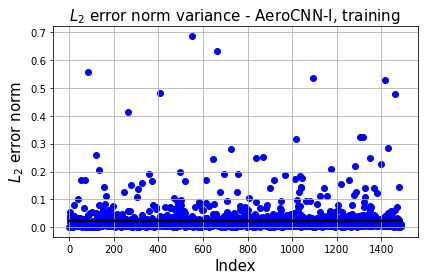

In [53]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-I, training', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

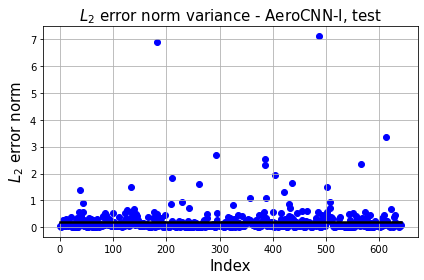

In [54]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-I, test', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

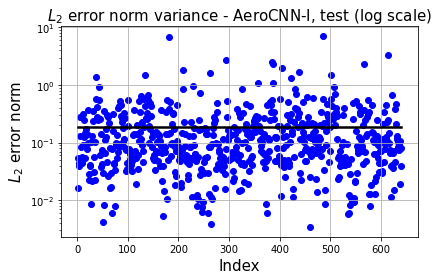

In [55]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-I, test (log scale)', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

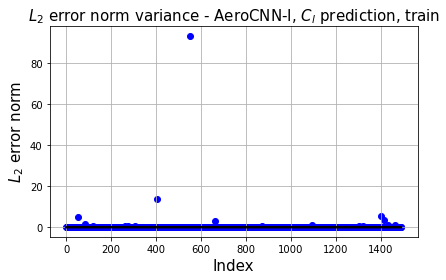

In [56]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_Cl_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_Cl_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-I, $C_l$ prediction, train', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

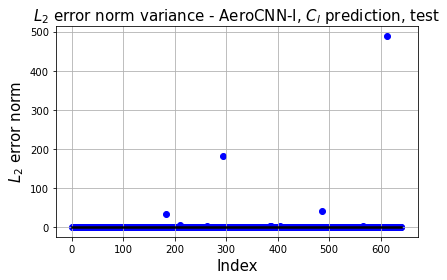

In [57]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_Cl_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_Cl_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-I, $C_l$ prediction, test', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

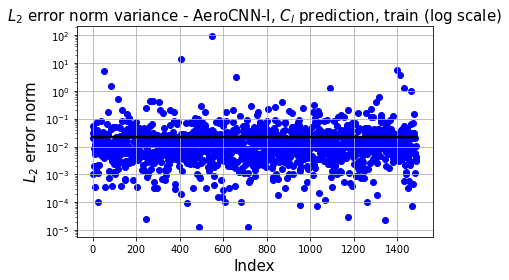

In [58]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_Cl_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_Cl_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-I, $C_l$ prediction, train (log scale)', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

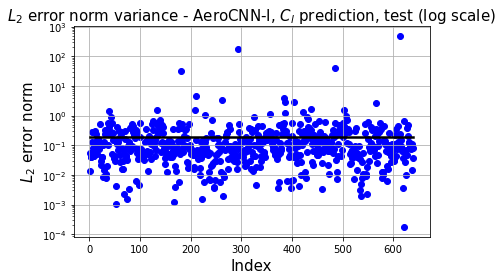

In [59]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_Cl_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_Cl_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-I, $C_l$ prediction, test (log scale)', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

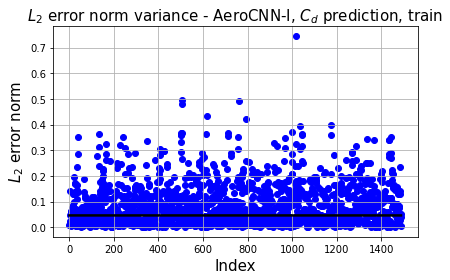

In [60]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_Cd_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_Cd_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-I, $C_d$ prediction, train', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

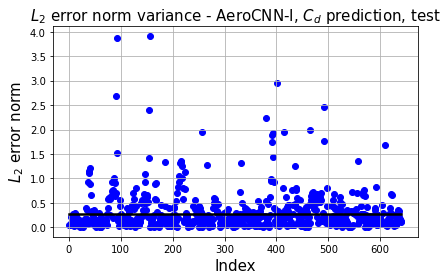

In [61]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_Cd_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_Cd_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-I, $C_d$ prediction, test', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

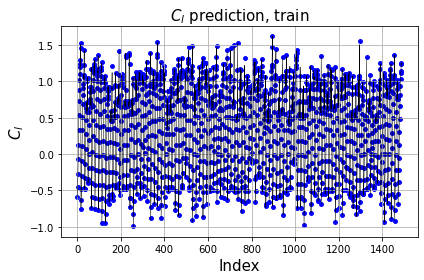

In [62]:
plt.plot(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), y_train[:,0,:], 'k',lw=0.5)
plt.scatter(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), decoded_train[:,0,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.title(r'$C_l$ prediction, train', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

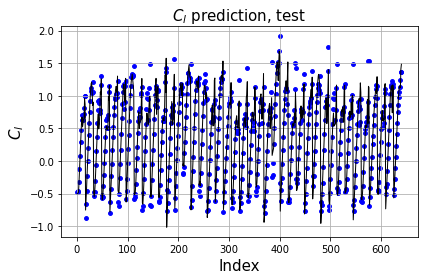

In [63]:
plt.plot(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), y_test[:,0,:], 'k',lw=1)
plt.scatter(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), decoded_test[:,0,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.title(r'$C_l$ prediction, test', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

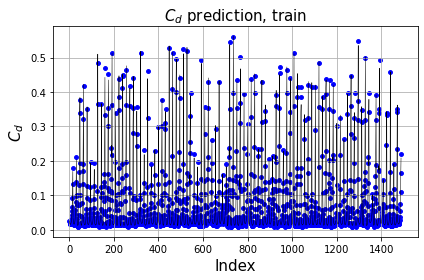

In [64]:
plt.plot(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), y_train[:,1,:], 'k',lw=0.5)
plt.scatter(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), decoded_train[:,1,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.title(r'$C_d$ prediction, train', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

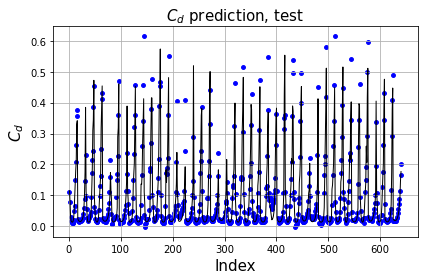

In [65]:
plt.plot(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), y_test[:,1,:], 'k',lw=1)
plt.scatter(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), decoded_test[:,1,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.title(r'$C_d$ prediction, test', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

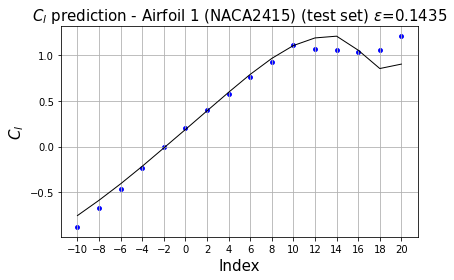

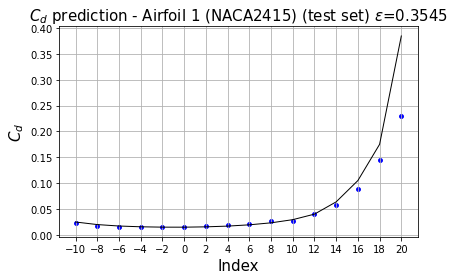

In [109]:
airfoiltest1_predict = decoded_test[16*1:16*2]

airfoiltest1_cl=y_test[16*1:16*2,0,:]
airfoiltest1_cd=y_test[16*1:16*2,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest1_predict[:,0,:] - airfoiltest1_cl)**2) / np.sum(airfoiltest1_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest1_predict[:,1,:] - airfoiltest1_cd)**2) / np.sum(airfoiltest1_cd**2))

plt.plot(alpha, airfoiltest1_cl.reshape(16,), 'k', lw=1)
plt.scatter(alpha, airfoiltest1_predict[:,0,:].reshape(16,), c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 1 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[1*16][0])[2:-1], epsilonCl), fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest1_cd.reshape(16,), 'k', lw=1)
plt.scatter(alpha, airfoiltest1_predict[:,1,:].reshape(16,), c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 1 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[1*16][0])[2:-1], epsilonCd), fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

In [67]:
decoded_test.shape

(640, 2, 1)

In [68]:
np.unique(geo_test)

array([b'NACA000834', b'NACA0010', b'NACA001034', b'NACA001264',
       b'NACA0024', b'NACA1408', b'NACA2408', b'NACA2411', b'NACA2415',
       b'NACA2418', b'NACA4412', b'NACA4415', b'NACA4421', b'NACA63010a',
       b'NACA63012a', b'NACA631412', b'NACA63210', b'NACA632415',
       b'NACA632615', b'NACA634221', b'NACA64008a', b'NACA64108',
       b'NACA64110', b'NACA6412', b'NACA64206', b'NACA64209',
       b'NACA64a210', b'NACA651412', b'NACA661212', b'NACA663218',
       b'RAE100', b'RAE101', b'RAE102', b'RAE2822', b'RAE5212',
       b'RAE5214', b'RAE69CK', b'RAF19', b'RAF31', b'RAF48'], dtype='|S32')

In [69]:
geo_test.shape[0]/16

40.0

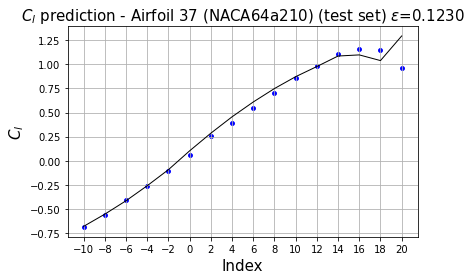

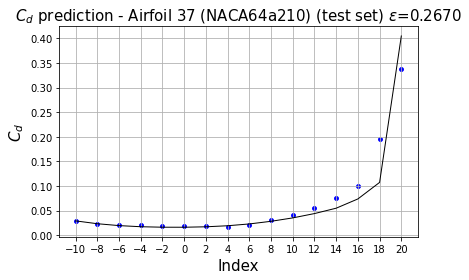

In [110]:
airfoiltest37_predict = decoded_test[16*36:16*37]

airfoiltest37_cl=y_test[16*36:16*37,0,:]
airfoiltest37_cd=y_test[16*36:16*37,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest37_predict[:,0,:] - airfoiltest37_cl)**2) / np.sum(airfoiltest37_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest37_predict[:,1,:] - airfoiltest37_cd)**2) / np.sum(airfoiltest37_cd**2))

plt.plot(alpha, airfoiltest37_cl.reshape(16,), 'k', lw=1)
plt.scatter(alpha, airfoiltest37_predict[:,0,:].reshape(16,), c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 37 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[37*16][0])[2:-1], epsilonCl), fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest37_cd.reshape(16,), 'k', lw=1)
plt.scatter(alpha, airfoiltest37_predict[:,1,:].reshape(16,), c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 37 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[37*16][0])[2:-1], epsilonCd), fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

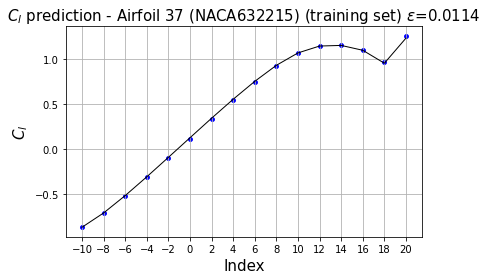

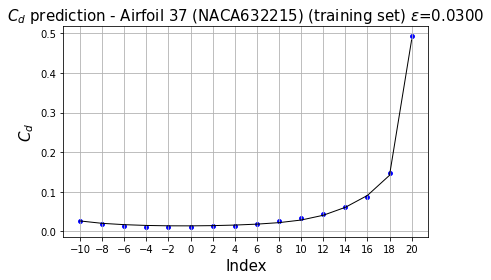

In [107]:
airfoiltrain37_predict = decoded_train[16*36:16*37]

airfoiltrain37_cl=y_train[16*36:16*37,0,:]
airfoiltrain37_cd=y_train[16*36:16*37,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltrain37_predict[:,0,:] - airfoiltrain37_cl)**2) / np.sum(airfoiltrain37_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltrain37_predict[:,1,:] - airfoiltrain37_cd)**2) / np.sum(airfoiltrain37_cd**2))

plt.plot(alpha, airfoiltrain37_cl.reshape(16,), 'k', lw=1)
plt.scatter(alpha, airfoiltrain37_predict[:,0,:].reshape(16,), c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title('$C_l$ prediction - Airfoil 37 (%s) (training set) $\epsilon$=%.4f' % (str(geo_train[36*16][0])[2:-1], epsilonCl), fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltrain37_cd.reshape(16,), 'k', lw=1)
plt.scatter(alpha, airfoiltrain37_predict[:,1,:].reshape(16,), c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title('$C_d$ prediction - Airfoil 37 (%s) (training set) $\epsilon$=%.4f' % (str(geo_train[36*16][0])[2:-1], epsilonCd), fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))

In [106]:
decoded_train.shape

(1488, 2, 1)

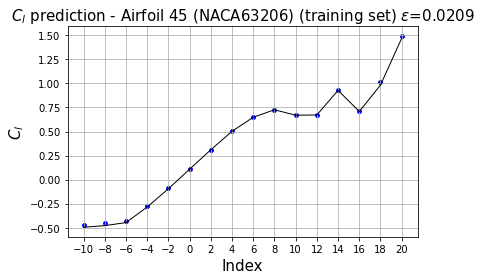

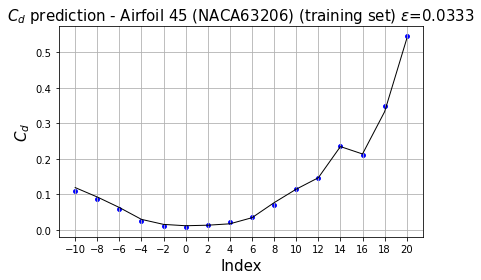

In [112]:
airfoiltrain45_predict = decoded_train[16*44:16*45]

airfoiltrain45_cl=y_train[16*44:16*45,0,:]
airfoiltrain45_cd=y_train[16*44:16*45,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltrain45_predict[:,0,:] - airfoiltrain45_cl)**2) / np.sum(airfoiltrain45_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltrain45_predict[:,1,:] - airfoiltrain45_cd)**2) / np.sum(airfoiltrain45_cd**2))

plt.plot(alpha, airfoiltrain45_cl.reshape(16,), 'k', lw=1)
plt.scatter(alpha, airfoiltrain45_predict[:,0,:].reshape(16,), c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 45 (%s) (training set) $\epsilon$=%.4f' % (str(geo_train[44*16][0])[2:-1], epsilonCl),
          fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltrain45_cd.reshape(16,), 'k', lw=1)
plt.scatter(alpha, airfoiltrain45_predict[:,1,:].reshape(16,), c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 45 (%s) (training set) $\epsilon$=%.4f' % (str(geo_train[44*16][0])[2:-1], epsilonCd),
          fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

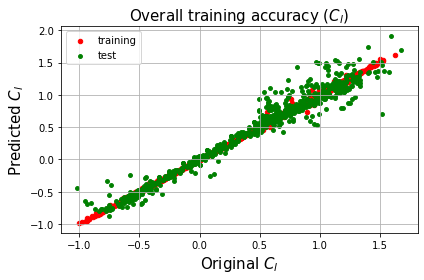

In [71]:
plt.scatter(y_train[:,0,:], decoded_train[:,0,:], c='r', s=20)
plt.scatter(y_test[:,0,:], decoded_test[:,0,:], c='g', s=15)
plt.xlabel('Original $C_l$', fontsize=15)
plt.ylabel('Predicted $C_l$', fontsize=15)
plt.title('Overall training accuracy ($C_l$)', fontsize=15)

plt.grid()
plt.legend(['training', 'test'])
plt.tight_layout()
plt.show()

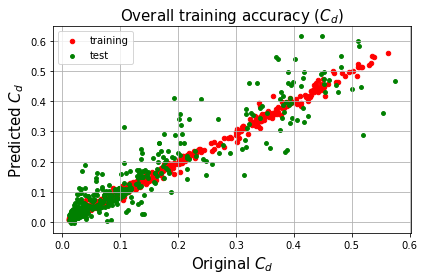

In [72]:
plt.scatter(y_train[:,1,:], decoded_train[:,1,:], c='r', s=20)
plt.scatter(y_test[:,1,:], decoded_test[:,1,:], c='g', s=15)
plt.xlabel('Original $C_d$', fontsize=15)
plt.ylabel('Predicted $C_d$', fontsize=15)
plt.title('Overall training accuracy ($C_d$)', fontsize=15)
plt.grid()
plt.legend(['training', 'test'])
plt.tight_layout()
plt.show()

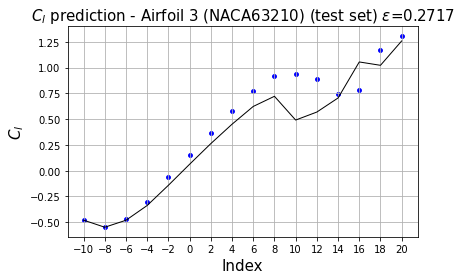

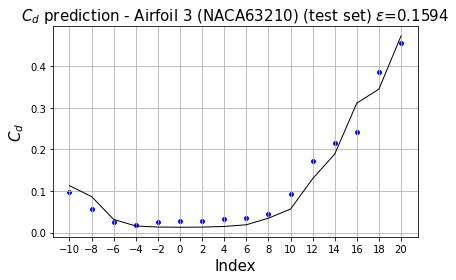

In [113]:
airfoiltest1_predict = decoded_test[16*2:16*3]

airfoiltest1_cl=y_test[16*2:16*3,0,:]
airfoiltest1_cd=y_test[16*2:16*3,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest1_predict[:,0,:] - airfoiltest1_cl)**2) / np.sum(airfoiltest1_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest1_predict[:,1,:] - airfoiltest1_cd)**2) / np.sum(airfoiltest1_cd**2))

plt.plot(alpha, airfoiltest1_cl.reshape(16,), 'k', lw=1)
plt.scatter(alpha, airfoiltest1_predict[:,0,:].reshape(16,), c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 3 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[2*16][0])[2:-1], epsilonCl), fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest1_cd.reshape(16,), 'k', lw=1)
plt.scatter(alpha, airfoiltest1_predict[:,1,:].reshape(16,), c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 3 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[2*16][0])[2:-1], epsilonCd), fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

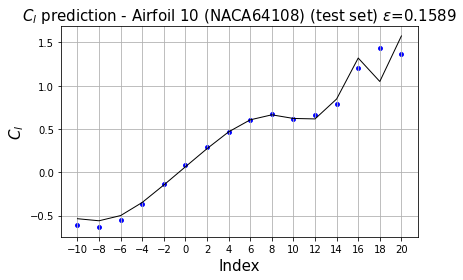

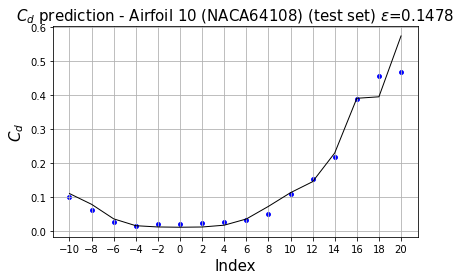

In [114]:
airfoiltest1_predict = decoded_test[16*10:16*11]

airfoiltest1_cl=y_test[16*10:16*11,0,:]
airfoiltest1_cd=y_test[16*10:16*11,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest1_predict[:,0,:] - airfoiltest1_cl)**2) / np.sum(airfoiltest1_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest1_predict[:,1,:] - airfoiltest1_cd)**2) / np.sum(airfoiltest1_cd**2))

plt.plot(alpha, airfoiltest1_cl.reshape(16,), 'k', lw=1)
plt.scatter(alpha, airfoiltest1_predict[:,0,:].reshape(16,), c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 10 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[10*16][0])[2:-1], epsilonCl), fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest1_cd.reshape(16,), 'k', lw=1)
plt.scatter(alpha, airfoiltest1_predict[:,1,:].reshape(16,), c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 10 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[10*16][0])[2:-1], epsilonCd), fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()